In [17]:
import sys
import numpy as np
import pandas as pd
import torch
import torchvision
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
import numpy.random as random
from tqdm.notebook import tqdm
import os
import gc
from PIL import Image
import wandb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [2]:
!nvidia-smi

Wed May  1 20:27:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:B2:00.0 Off |                    0 |
| N/A   24C    P0              38W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
class LayerNorm(nn.Module):
    """ LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

class GRN(nn.Module):
    """ GRN (Global Response Normalization) layer
    """
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        Gx = torch.norm(x, p=2, dim=(1,2), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x

In [4]:
img_config = {
    'batch_size': 16, # Increase this if your GPU can handle it
    'lr': 1e-3,
    'epochs': 30,
    # Include other parameters as needed.
}

class CustomImageDataset(torchvision.datasets.VisionDataset):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        # Assuming that the images are organized in subfolders representing classes.
        self.classes, self.class_to_idx = self._find_classes(root)
        self.samples = self.make_dataset(root, self.class_to_idx)
        self.targets = [s[1] for s in self.samples]

    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.
        """
        if not os.path.isdir(dir):
            raise FileNotFoundError(f"Couldn't find directory: {dir}")
        classes = sorted(entry.name for entry in os.scandir(dir) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        classes = classes[0:]
        return classes, class_to_idx

    def make_dataset(self, directory, class_to_idx):
        instances = []
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(directory, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir)):
                for fname in fnames:
                    if fname.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff', 'tif')):
                        path = os.path.join(root, fname)
                        instances.append((path, class_index))
        return instances

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        
        sample = self.loader(path)
            

        if self.transform is not None:
            sample = self.transform(sample)
            # mask = np.ones_like(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        # if self.target_transform is None:
        #     target = np.eye(len(self.classes))[int(target)]
        return sample, target

    def __len__(self):
        return len(self.samples)


    def loader(self, path):
        try:
            # Open the image file, avoiding automatic resource management to control the closing process
            with open(path, 'rb') as f:
              image = Image.open(path)
              if image.mode in ['I', 'F', 'I;16', 'I;16L', 'I;16B', 'I;16N']:
                    image_array = np.array(image, dtype=np.int32)
                    max_val = image_array.max()
                    if max_val > 0:image = Image.fromarray((image_array / max_val * 255).astype(np.uint8))
              if image.mode != 'RGB': image = image.convert('RGB')

            return image
        except Exception:
            print(f"Failed to load image {path}. Skipping.")
            return None


class ClassificationVisualizeDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx])
        if image.mode in ['I', 'F', 'I;16', 'I;16L', 'I;16B', 'I;16N']:
            image_array = np.array(image, dtype=np.int32)
            max_val = image_array.max()
            if max_val > 0:image = Image.fromarray((image_array / max_val * 255).astype(np.uint8))
        if image.mode != 'RGB': image = image.convert('RGB')
        # mask = np.ones_like(self.transforms(image))
        return self.transforms(image)# , mask

mean=[0.4195, 0.3118, 0.1418]
std=[0.2289, 0.2239, 0.2249]
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(degrees=[-15, 15], scale=(1/1.2, 1.2)),  # Random stretching
    # torchvision.transforms.GaussianBlur(kernel_size=(7,7),sigma=(0.1,0.2)),
    torchvision.transforms.Resize((224, 224)), 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean,std)
])
valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean,std)
])

TRAIN_DIR = '/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean/train'
VAL_DIR = "/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean/dev"
TEST_DIR = "/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean/test"

train_dataset   = CustomImageDataset(TRAIN_DIR, transform= train_transforms)
valid_dataset   = CustomImageDataset(VAL_DIR, transform= valid_transforms)
test_dataset    = ClassificationVisualizeDataset(TEST_DIR, transforms =valid_transforms)


train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = img_config['batch_size'],
    shuffle     = True,
    num_workers = 10,
    pin_memory = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = img_config['batch_size'],
    shuffle     = False,
    num_workers = 8,
    pin_memory = True
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = img_config['batch_size'],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True
)

In [5]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", img_config['batch_size'])
print("Train batches        : ", train_loader.__len__())

Number of classes    :  3
No. of train images  :  19588
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  16
Train batches        :  1225


In [6]:
print("Number of classes    : ", len(valid_dataset.classes))
print("No. of valid images  : ", valid_dataset.__len__() )
print("Shape of image       : ", valid_dataset[0][0].shape)
print("Batch size           : ", img_config['batch_size'])
print("Valid batches        : ", valid_loader.__len__())

Number of classes    :  3
No. of valid images  :  1224
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  16
Valid batches        :  77


In [7]:
print("No. of test images  : ", test_dataset.__len__() )
print("Shape of image      : ", test_dataset[0].shape)
print("Batch size          : ", img_config['batch_size'])
print("Test batches        : ", test_loader.__len__())

No. of test images  :  3674
Shape of image      :  torch.Size([3, 224, 224])
Batch size          :  16
Test batches        :  230


I


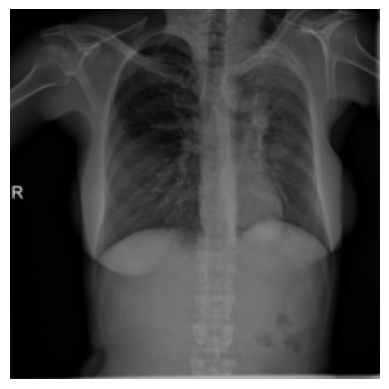

In [8]:
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
image_path = "/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean-v2/train/0/16098_bimcv_neg.png"

def load_and_preprocess_images(image_path):
    image = Image.open(image_path)
    print(image.mode)
    
    if image.mode == 'I':
        image_array = np.array(image, dtype=np.int32)
        max_val = image_array.max()
        if max_val > 0:image = Image.fromarray((image_array / max_val * 255).astype(np.uint8))
        
    image = image.convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image)
    
    return image_tensor

image_tensor = load_and_preprocess_images(image_path)
image_tensor = image_tensor.permute(1, 2, 0).numpy()

plt.imshow(image_tensor)
plt.axis('off')
plt.show()

In [33]:
def calculate_mean_std(loader):
    channel_sum, channel_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channel_sum += torch.mean(data, dim=[0, 2, 3])
        channel_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1
        
    mean = channel_sum / num_batches
    std = (channel_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


In [27]:
mean, std = get_mean_std(train_loader)
print(f"{mean},{std}")

  0%|          | 0/1225 [00:00<?, ?it/s]

tensor([0.4195, 0.3118, 0.1418]),tensor([0.2289, 0.2239, 0.2249])


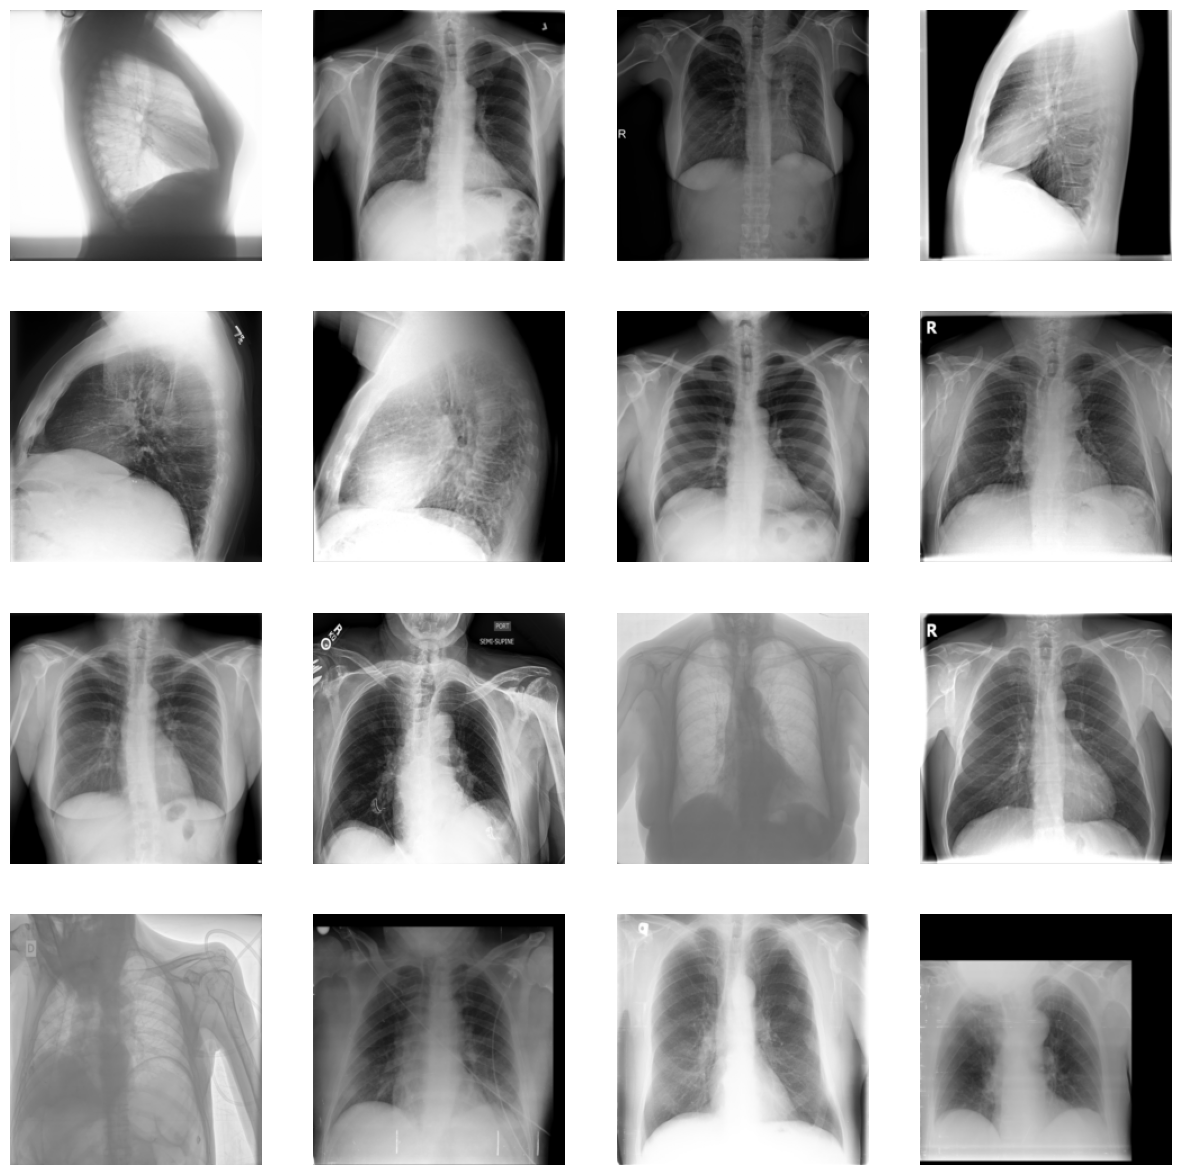

In [45]:
r, c    = [4, 4]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = train_dataset, # dont wanna see the images with transforms
    batch_size  = img_config['batch_size'],
    shuffle     = False,
)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].clamp(0, 1).numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

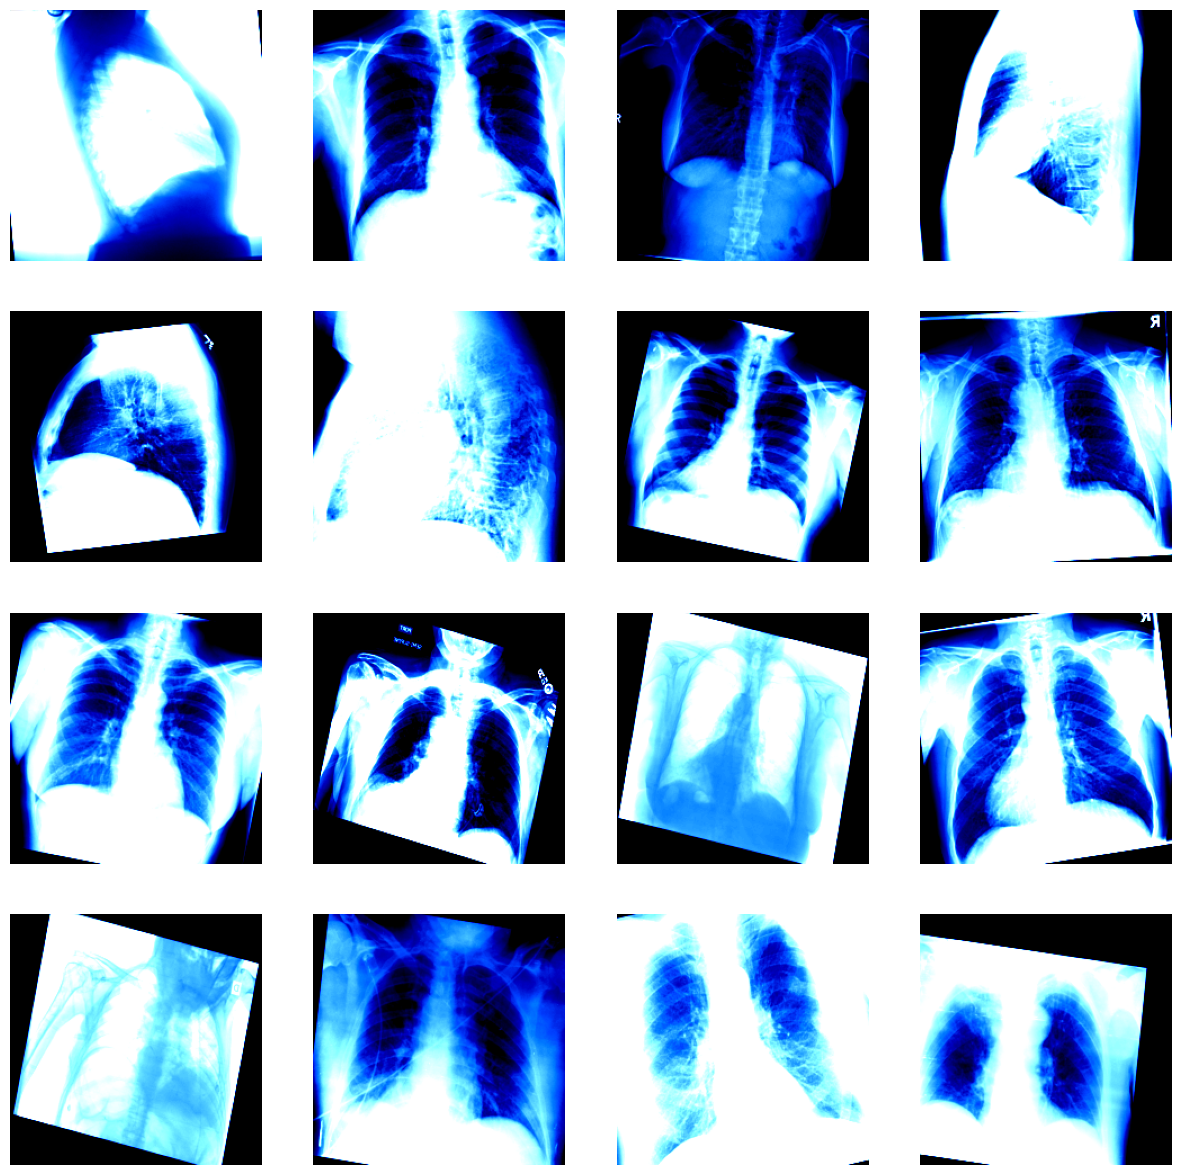

In [48]:
r, c    = [4, 4]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = train_dataset, # dont wanna see the images with transforms
    batch_size  = img_config['batch_size'],
    shuffle     = False,
)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].clamp(0, 1).numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

In [8]:
class Block(nn.Module):
    """ ConvNeXtV2 Block.
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
    """
    def __init__(self, dim, drop_path=0.):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.grn = GRN(4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXtV2(nn.Module):
    """ ConvNeXt V2
        
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], 
                 drop_path_rate=0., head_init_scale=1.
                 ):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x
    
def convnextv2_atto(**kwargs):
    model = ConvNeXtV2(depths=[2, 2, 6, 2], dims=[40, 80, 160, 320], **kwargs)
    return model

def convnextv2_femto(**kwargs):
    model = ConvNeXtV2(depths=[2, 2, 6, 2], dims=[48, 96, 192, 384], **kwargs)
    return model

def convnext_pico(**kwargs):
    model = ConvNeXtV2(depths=[2, 2, 6, 2], dims=[64, 128, 256, 512], **kwargs)
    return model

def convnextv2_nano(**kwargs):
    model = ConvNeXtV2(depths=[2, 2, 8, 2], dims=[80, 160, 320, 640], **kwargs)
    return model

def convnextv2_tiny(**kwargs):
    model = ConvNeXtV2(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    return model

def convnextv2_base(**kwargs):
    model = ConvNeXtV2(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], **kwargs)
    return model

def convnextv2_large(**kwargs):
    model = ConvNeXtV2(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], **kwargs)
    return model

def convnextv2_huge(**kwargs):
    model = ConvNeXtV2(depths=[3, 3, 27, 3], dims=[352, 704, 1408, 2816], **kwargs)
    return model

In [9]:
model = convnextv2_tiny()
# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"{torch.cuda.device_count()} GPUs are available")
    model = nn.DataParallel(model)
model = model.to(DEVICE)
summary(model, (3, 224, 224))

2 GPUs are available
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
            Conv2d-2           [-1, 96, 56, 56]           4,704
         LayerNorm-3           [-1, 96, 56, 56]             192
         LayerNorm-4           [-1, 96, 56, 56]             192
            Conv2d-5           [-1, 96, 56, 56]           4,800
            Conv2d-6           [-1, 96, 56, 56]           4,800
         LayerNorm-7           [-1, 56, 56, 96]             192
         LayerNorm-8           [-1, 56, 56, 96]             192
            Linear-9          [-1, 56, 56, 384]          37,248
           Linear-10          [-1, 56, 56, 384]          37,248
             GELU-11          [-1, 56, 56, 384]               0
             GELU-12          [-1, 56, 56, 384]               0
              GRN-13          [-1, 56, 56, 384]               0
              GRN-

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=img_config['lr'], weight_decay=1e-4)
# scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=1, verbose=True, threshold=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

scaler = torch.cuda.amp.GradScaler() # (Mixed precision training)


In [11]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0
    
    num_classes = 3
    TP = torch.zeros(num_classes, dtype=torch.long, device='cuda')
    FP = torch.zeros(num_classes, dtype=torch.long, device='cuda')
    FN = torch.zeros(num_classes, dtype=torch.long, device='cuda')
    precision = torch.zeros(num_classes, dtype=torch.float, device='cuda')

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): 
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())
        
        for k in range(num_classes):
            TP[k] += ((torch.argmax(outputs, axis=1) == k) & (labels == k)).sum()
            FP[k] += ((torch.argmax(outputs, axis=1) == k) & (labels != k)).sum()
            FN[k] += ((torch.argmax(outputs, axis=1) != k) & (labels == k)).sum()

        for k in range(num_classes):
            if TP[k] + FP[k] > 0:
                precision[k] = TP[k] / (TP[k] + FP[k])

        #add some details of monitor training
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (img_config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.06f}".format(float(optimizer.param_groups[0]['lr'])),
            precision_0 = "{:.04f}".format(precision[0].item()),
            precision_1 = "{:.04f}".format(precision[1].item()),
            precision_2 = "{:.04f}".format(precision[2].item())
        )

        scaler.scale(loss).backward() # replacement for loss.backward()
        scaler.step(optimizer) # replacement for optimizer.step()
        scaler.update()


        batch_bar.update() # Update tqdm bar

    batch_bar.close() 

    acc         = 100 * num_correct / (img_config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [19]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (img_config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (img_config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

def validate(model, dataloader, criterion):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    # Lists to collect true and predicted labels for the confusion matrix
    all_labels = []
    all_preds = []

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Update the number of correctly classified images
        preds = torch.argmax(outputs, axis=1)
        num_correct += int((preds == labels).sum())
        total_loss += float(loss.item())

        # Collect all true and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (img_config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (img_config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non', 'Non-Covid-Pne','Covid-Pne'])
    
    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return acc, total_loss

In [13]:
gc.collect() 
torch.cuda.empty_cache()

In [ ]:
wandb.login(key="")

In [ ]:

run = wandb.init(
    #name = "", #
    reinit = False, ### Allows reinitalizing runs
    #id = "",### Insert specific run id here if you want to resume a previous run
    resume = "allow", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "X-ray", ### Project should be created in your wandb account
    config = img_config ### Wandb Config for your run
)

In [14]:
checkpoint = torch.load('/jet/home/mgao5/Conv_Next_V2/tiny_dp_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch']
val_acc = checkpoint['val_acc']

In [18]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

In [15]:
scheduler.get_last_lr()

[4.3980465111040044e-05]

In [18]:
# scheduler.step()
# scheduler.get_last_lr()

In [ ]:
best_valacc = 0

for epoch in range(img_config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.06f}".format(
        epoch + 1,
        img_config['epochs'],
        train_acc,
        train_loss,
        curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)
    scheduler.step()


    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc,
               'validation_loss': val_loss, "learning_Rate": curr_lr})

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch}, '/jet/home/mgao5/Conv_Next_V2/tiny_dp_checkpoint.pth')
      best_valacc = val_acc
      wandb.save('checkpoint.pth')
# run.finish()

Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 1/30: 
Train Acc 58.6378%	 Train Loss 0.8759	 Learning Rate 0.000328


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 58.3604%	 Val Loss 0.8581
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 2/30: 
Train Acc 59.4286%	 Train Loss 0.8645	 Learning Rate 0.000262


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 60.4708%	 Val Loss 0.8227
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 3/30: 
Train Acc 59.9082%	 Train Loss 0.8364	 Learning Rate 0.000210


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 60.9578%	 Val Loss 0.7946
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 4/30: 
Train Acc 60.4133%	 Train Loss 0.8190	 Learning Rate 0.000168


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 61.6883%	 Val Loss 0.7865
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 5/30: 
Train Acc 61.1837%	 Train Loss 0.8064	 Learning Rate 0.000134


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 60.9578%	 Val Loss 0.7829


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 6/30: 
Train Acc 61.3776%	 Train Loss 0.7970	 Learning Rate 0.000107


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 63.4740%	 Val Loss 0.7802
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 7/30: 
Train Acc 61.9796%	 Train Loss 0.7868	 Learning Rate 0.000086


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 62.0130%	 Val Loss 0.7710


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 8/30: 
Train Acc 62.3163%	 Train Loss 0.7835	 Learning Rate 0.000069


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 62.2565%	 Val Loss 0.7676


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 9/30: 
Train Acc 62.5867%	 Train Loss 0.7769	 Learning Rate 0.000055


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 63.9610%	 Val Loss 0.7619
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]

In [ ]:
best_valacc = 0

for epoch in range(img_config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.06f}".format(
        epoch + 1,
        img_config['epochs'],
        train_acc,
        train_loss,
        curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)
    scheduler.step()


    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc,
               'validation_loss': val_loss, "learning_Rate": curr_lr})

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch}, '/jet/home/mgao5/Conv_Next_V2/V2_checkpoint.pth')
      best_valacc = val_acc
      wandb.save('checkpoint.pth')
# run.finish()

Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 1/20: 
Train Acc 69.2377%	 Train Loss 0.6602	 Learning Rate 0.000086


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 68.0921%	 Val Loss 0.6852
Saving model


Train:   0%|          | 0/897 [00:00<?, ?it/s]

wandb: Network error (SSLError), entering retry loop.



Epoch 2/20: 
Train Acc 69.4816%	 Train Loss 0.6577	 Learning Rate 0.000069


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.2149%	 Val Loss 0.6957


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 3/20: 
Train Acc 69.6767%	 Train Loss 0.6549	 Learning Rate 0.000055


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 66.8860%	 Val Loss 0.6826


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 4/20: 
Train Acc 70.0460%	 Train Loss 0.6499	 Learning Rate 0.000044


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.5439%	 Val Loss 0.6788


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 5/20: 
Train Acc 69.9345%	 Train Loss 0.6488	 Learning Rate 0.000035


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.5439%	 Val Loss 0.6821


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 6/20: 
Train Acc 70.3177%	 Train Loss 0.6477	 Learning Rate 0.000028


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.1053%	 Val Loss 0.6785


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 7/20: 
Train Acc 70.2202%	 Train Loss 0.6463	 Learning Rate 0.000023


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.1053%	 Val Loss 0.6791


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 8/20: 
Train Acc 70.2620%	 Train Loss 0.6445	 Learning Rate 0.000018


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.5439%	 Val Loss 0.6783


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 9/20: 
Train Acc 70.3665%	 Train Loss 0.6447	 Learning Rate 0.000014


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 68.0921%	 Val Loss 0.6761
Saving model


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 10/20: 
Train Acc 70.5686%	 Train Loss 0.6421	 Learning Rate 0.000012


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.2149%	 Val Loss 0.6799


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 11/20: 
Train Acc 70.4013%	 Train Loss 0.6423	 Learning Rate 0.000009


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 66.8860%	 Val Loss 0.6796


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 12/20: 
Train Acc 70.6173%	 Train Loss 0.6411	 Learning Rate 0.000007


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 66.3377%	 Val Loss 0.6824


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 13/20: 
Train Acc 70.3804%	 Train Loss 0.6404	 Learning Rate 0.000006


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.6535%	 Val Loss 0.6773


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 14/20: 
Train Acc 70.6522%	 Train Loss 0.6400	 Learning Rate 0.000005


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 66.9956%	 Val Loss 0.6788


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 15/20: 
Train Acc 70.7497%	 Train Loss 0.6413	 Learning Rate 0.000004


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.6535%	 Val Loss 0.6754


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 16/20: 
Train Acc 70.6313%	 Train Loss 0.6393	 Learning Rate 0.000003


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.3246%	 Val Loss 0.6786


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 17/20: 
Train Acc 70.6731%	 Train Loss 0.6395	 Learning Rate 0.000002


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.2149%	 Val Loss 0.6770


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 18/20: 
Train Acc 70.6382%	 Train Loss 0.6390	 Learning Rate 0.000002


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.2149%	 Val Loss 0.6766


Train:   0%|          | 0/897 [00:00<?, ?it/s]

Val:   0%|          | 0/77 [00:00<?, ?it/s]

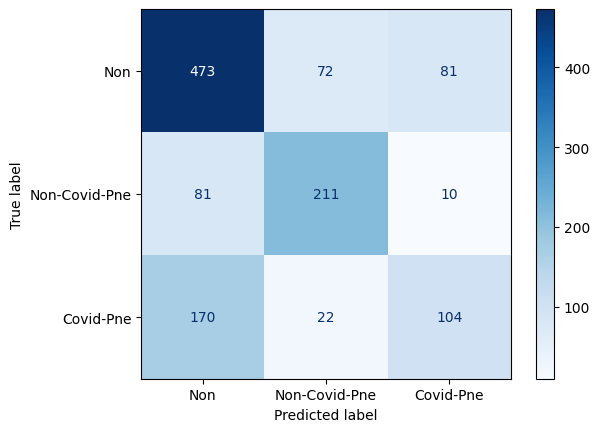

(63.96103896103896, 0.7619341646696066)

In [20]:
validate(model, valid_loader, criterion)

In [13]:
os.remove('/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean-v2/train/0/16874_bimcv_neg.png')

In [15]:
os.remove('/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean-v2/train/0/729_padchest.png')

In [10]:
os.path.exists('/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean-v2/train/0/16874_bimcv_neg.png')

False

In [16]:
os.path.exists('/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean-v2/train/0/729_padchest.png')

False